# Analicis Exploratorio:
- Rendimiento (Base 100)
- descripción
- Matriz de Correlació
- Histogramas
- Boxplot (caja)
- Poder Adquisitivo Real


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import numpy as np
from dotenv import load_dotenv
import os

load_dotenv()

# conf de estilo para los graficos
sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize'] = (12, 6)

# CONEXION A BD
DB_URL = (
    f"postgresql://{os.getenv('DB_USER')}:{os.getenv('DB_PASSWORD')}"
    f"@{os.getenv('DB_HOST')}:{os.getenv('DB_PORT')}/{os.getenv('DB_NAME')}"
)
engine = create_engine(DB_URL)

print("Conectado a la DB. cargando datos . . .")

# CARGAR FCI 
q_fci = """
SELECT fecha, billetera, vcp 
FROM rendimientos_fci 
WHERE billetera IN ('Mercado Pago', 'Ualá', 'Personal Pay')
ORDER BY fecha ASC
"""
df_fci = pd.read_sql(q_fci, engine)
df_fci['fecha'] = pd.to_datetime(df_fci['fecha'])

#pivot para que cada billetera sea una columna
df_fci_pivot = df_fci.pivot_table(index='fecha', columns='billetera', values='vcp')

# CARGAR DOLAR BLUE (filtramos fechas hasta hoy)
q_dolar = """
SELECT fecha, promedio as "Dolar Blue"
FROM cotizaciones_dolar_hist
WHERE tipo = 'Blue' AND fecha <= CURRENT_DATE 
ORDER BY fecha ASC
"""
df_dolar = pd.read_sql(q_dolar, engine)
df_dolar['fecha'] = pd.to_datetime(df_dolar['fecha'])
df_dolar = df_dolar.set_index('fecha')
# eliminar duplicados de fecha
df_dolar = df_dolar[~df_dolar.index.duplicated(keep='last')]

# CARGAR E "INTERCALAR" INFLACION 
q_inf = "SELECT fecha, valor FROM inflacion ORDER BY fecha ASC"
df_inf = pd.read_sql(q_inf, engine)
df_inf['fecha'] = pd.to_datetime(df_inf['fecha'])

# rango de fechas completo (desde el primer dia de datos hasta hoy)
fecha_inicio = df_dolar.index.min()
fecha_fin = df_dolar.index.max()
rango_completo = pd.date_range(start=fecha_inicio, end=fecha_fin, freq='D')

# preparar tabla de inflacion diaria
df_inf = df_inf.set_index('fecha').reindex(rango_completo).ffill()
df_daily_inf = pd.DataFrame(index=rango_completo)

# Convertir inflación mensual a diaria y acumulada
# -----> Formula: (1 + TasaMensual)^(1/30) - 1
df_daily_inf['Inflacion Diaria'] = (1 + df_inf['valor']/100)**(1/30) - 1
df_daily_inf['Inflacion Acumulada'] = (1 + df_daily_inf['Inflacion Diaria']).cumprod() * 100

# JUNTAR TODO EN UN SOLO DATAFRAME 
# Unimos todo sobre el calendario completo (Lun a Dom)
df_completo = pd.DataFrame(index=rango_completo)
df_completo.index.name = 'fecha'

df_completo = df_completo.join(df_fci_pivot)
df_completo = df_completo.join(df_dolar)
df_completo = df_completo.join(df_daily_inf[['Inflacion Acumulada', 'Inflacion Diaria']])


df_consolidado = df_completo.ffill().dropna() # ---> rellenamos los huecos de fin de semana (Forward Fill)

print("✅ Datos limpios y consolidados.")
display(df_consolidado.tail())

Conectado a la DB. cargando datos . . .
✅ Datos limpios y consolidados.


,Mercado Pago,Personal Pay,Ualá,Dolar Blue,Inflacion Acumulada,Inflacion Diaria
fecha,,,,,,
2025-12-08,1108.283,42322.654,7257.306,1425.0,129.485657,0.000823
2025-12-09,1109.719,42404.866,7273.991,1435.0,129.592279,0.000823
2025-12-10,1110.085,42423.281,7278.155,1440.0,129.698989,0.000823
2025-12-11,1110.452,42442.053,7282.287,1440.0,129.805786,0.000823
2025-12-12,1110.818,42461.121,7286.387,1435.0,129.912672,0.000823


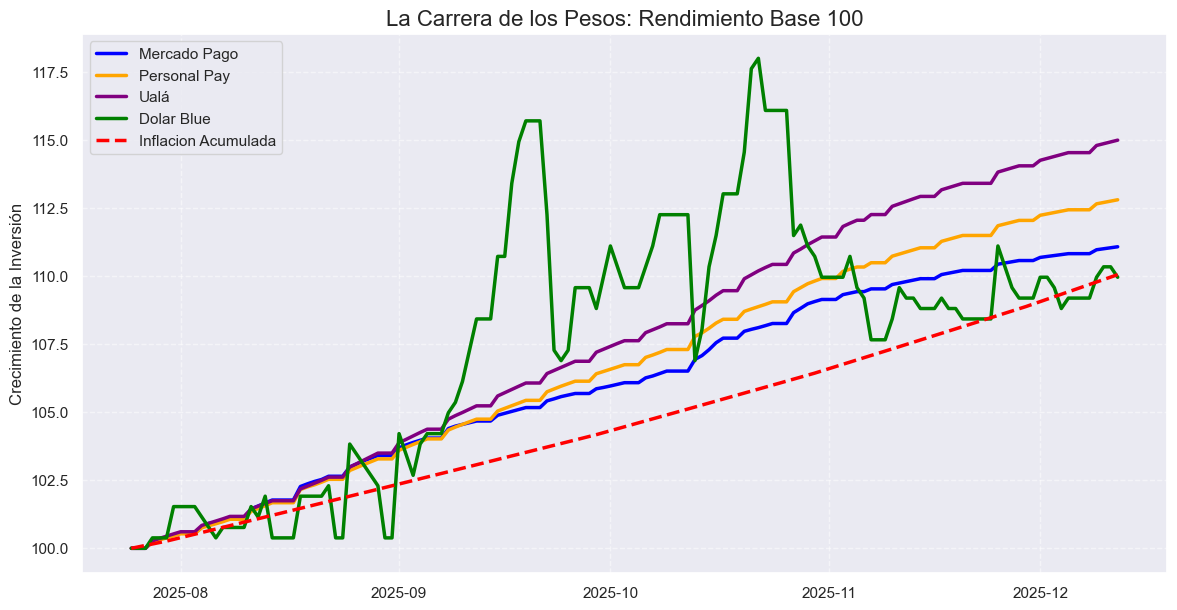

In [2]:
# normalizar a Base 100 osea que todo empieza en 100)
df_base100 = (df_consolidado / df_consolidado.iloc[0]) * 100

# graficar
plt.figure(figsize=(14, 7))

colores = {'Mercado Pago': 'blue', 'Personal Pay': 'orange', 'Ualá': 'purple', 
           'Dolar Blue': 'green', 'Inflacion Acumulada': 'red'}

for col in ['Mercado Pago', 'Personal Pay', 'Ualá', 'Dolar Blue', 'Inflacion Acumulada']:
    if col in df_base100.columns:
        estilo = '--' if 'Inflacion' in col else '-'
        plt.plot(df_base100.index, df_base100[col], label=col, 
                 color=colores.get(col), linestyle=estilo, linewidth=2.5)

plt.title('La Carrera de los Pesos: Rendimiento Base 100', fontsize=16)
plt.ylabel('Crecimiento de la Inversión')
plt.legend()
plt.grid(True, alpha=0.5, linestyle='--')
plt.show()

Observación:

La Inflación termina aproximadamente en 109 (un 9% acumulado).

las billeteras (🟣🟠🔵) son escaleras suaves ascendentes. no bajan nunca (riesgo muy bajo)

El Ganador por ahora es Ualá (🟣) se despega del resto, terminando cerca de 114.5 (14.5% de ganancia)(14.5% ganancia vs 9% inflación).

El Dólar Blue (🟢) tuvo su pico en a mediados de septiembre y fines de octubre, llegando a tocar casi 118 (18% de ganancia)

después de los picos, el precio se desploma, en el final (principios de Diciembre) el Dólar termina en ~109.5.



---
variación porcentual diaria (cuánto subió o bajó respecto a ayer)
---

In [3]:
# usamos estas columnas 
cols_interes = ['Mercado Pago', 'Personal Pay', 'Ualá', 'promedio', 'inflacion_acumulada']

# filtrar las columnas en el df
cols_existentes = [c for c in cols_interes if c in df_consolidado.columns]
df_numerico = df_consolidado[cols_existentes].copy()


# si hay varias filas para la misma fecha ----> ej: Blue y Oficial, nos quedamos con la ultima o el promedio
df_numerico = df_numerico.groupby(df_numerico.index).mean()

#calcular variacion
df_returns = df_numerico.pct_change().dropna() * 100

# renombrar
if 'promedio' in df_returns.columns:
    df_returns = df_returns.rename(columns={'promedio': 'Dolar Blue'})

if 'inflacion_acumulada' in df_returns.columns:
    df_returns = df_returns.rename(columns={'inflacion_acumulada': 'Inflación Diaria'})

print("📊 Variacion Diaria (%):")
display(df_returns.head())
display(df_returns.describe().round(3)) # ---> Estadísticas básicas para verificar

📊 Variacion Diaria (%):


,Mercado Pago,Personal Pay,Ualá
fecha,,,
2025-07-26,0.000000,0.000000,0.000000
2025-07-27,0.000000,0.000000,0.000000
2025-07-28,0.241400,0.228890,0.273106
2025-07-29,0.089684,0.080509,0.090032
2025-07-30,0.084121,0.075508,0.084478


,Mercado Pago,Personal Pay,Ualá
count,140.000,140.000,140.000
mean,0.075,0.086,0.100
std,0.091,0.096,0.107
min,0.000,0.000,0.000
25%,0.000,0.000,0.000
50%,0.056,0.076,0.089
75%,0.095,0.101,0.123
max,0.488,0.476,0.464


Observación: 

Vemos la rentabilidad promedio (mean):             <--- Este es el rendimiento promedio que te dio cada activo por día.

Ualá (0.102%): fue el mejor en promedio.           <--- (te pagó un 0.1% diario)

Personal Pay (0.088%): Segundo lugar.

Mercado Pago (0.077%): Tercer lugar.

Inflación Diaria (0.071%)

Conclusión: 
En este periodo visto 

las tres billeteras le ganaron a la inflación (todas están por encima del 0.071%).


Matriz de Correlacion (¿Quien se mueve con quien?) 
---

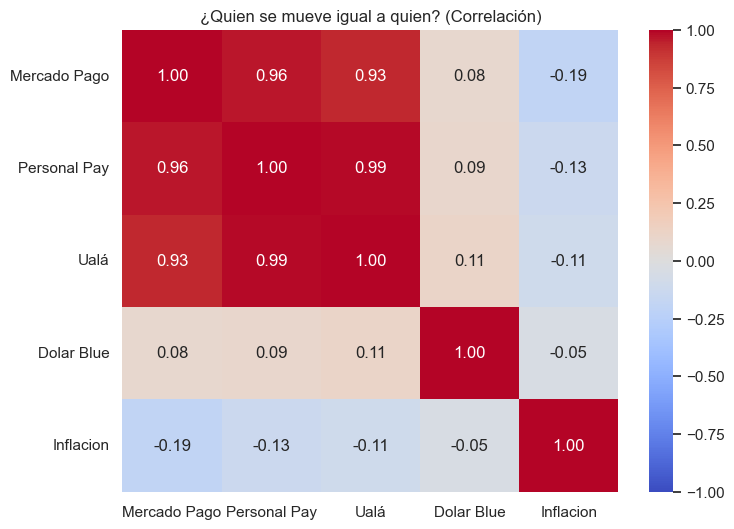

In [4]:
# calcular retornos "porcentuales" de los activos
cols_activos = ['Mercado Pago', 'Personal Pay', 'Ualá', 'Dolar Blue']
df_returns = df_consolidado[cols_activos].pct_change() * 100

# agregar la inflacion diaria ---> (ya es una tasa, solo la multi por 100)
df_returns['Inflacion'] = df_consolidado['Inflacion Diaria'] * 100
df_returns = df_returns.dropna()

# Matriz de correlacion
plt.figure(figsize=(8, 6))
sns.heatmap(df_returns.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title("¿Quien se mueve igual a quien? (Correlación)")
plt.show()

Observación:

Mercado Pago, Personal Pay y  Uala tienen valores  (0.96, 0.98, 0.93) osea tienen una correlación casi perfecta

conclución: tener la mitad de tu dinero en MP y la otra mitad en Uala es casi lo mismo que tener todo en una sola, si la tasa baja para una, baja para la otra tambien.

---
Distribución de Retornos (Histogramas)
---

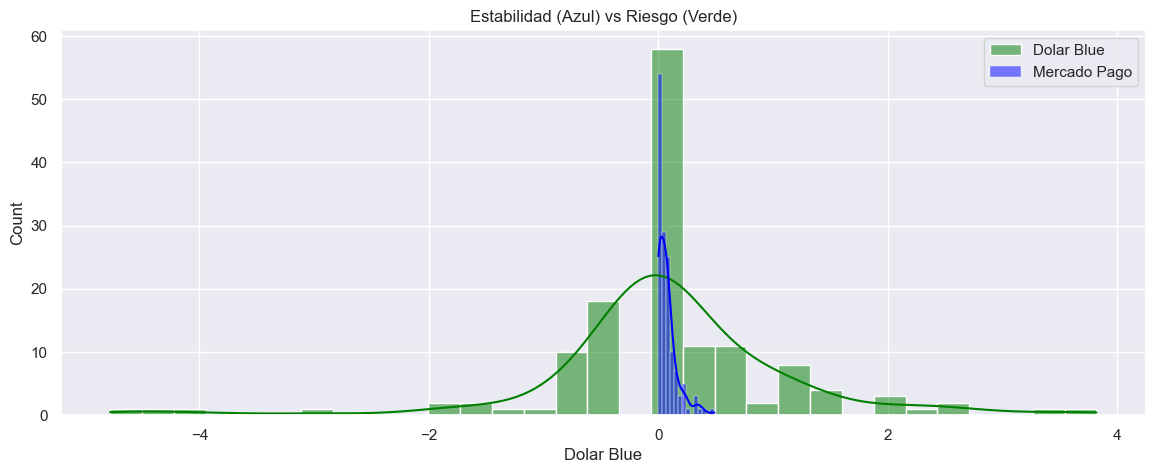

In [5]:
# Histograma
plt.figure(figsize=(14, 5))
sns.histplot(df_returns['Dolar Blue'], kde=True, color='green', label='Dolar Blue', alpha=0.5)
sns.histplot(df_returns['Mercado Pago'], kde=True, color='blue', label='Mercado Pago', alpha=0.5)
plt.title("Estabilidad (Azul) vs Riesgo (Verde)")
plt.legend()
plt.show()

Obesrvación:

Mercado Pago 🔵 casi todos los días rinde lo mismo (alrededor de 0.1% diario), no pierde dinero 

Dólar Blue 🟢 un día puedes ganar un 3% (derecha), pero otro día puedes perder un 6% de tu capital en pesos (izquierda). 

_Riesgo de Pérdida      

En MP 🔵 es Nulo (seguro)         

Dólar Blue 🟢 Hay días con retornos negativos fuertes (Volatilidad) 

_Potencial de Ganancia

MP 🔵 Limitado (techo bajo)

Dólar Blue 🟢 Alto (puede pegar saltos grandes)

Boxplot (Cajas y Bigotes) ---> Outliers (dias atipicos)
---


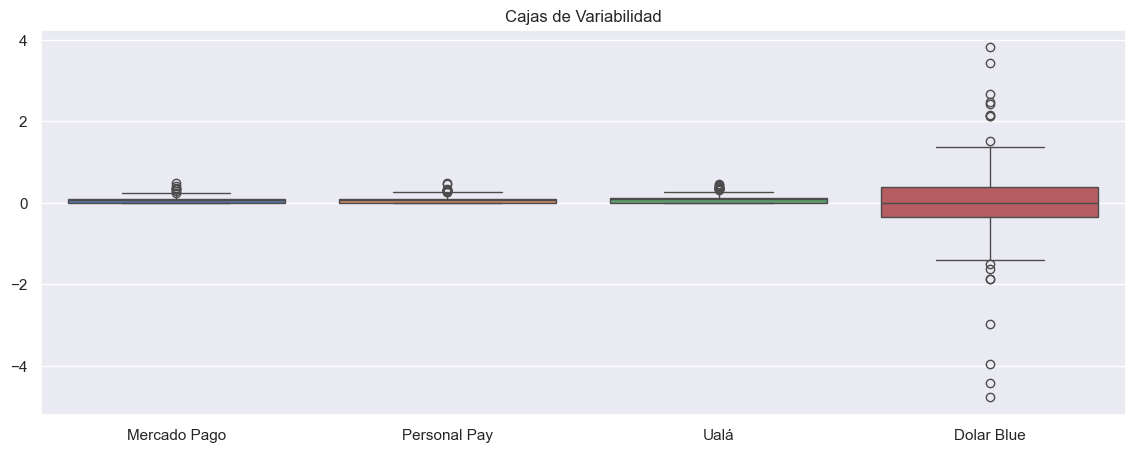

In [6]:
plt.figure(figsize=(14, 5))
sns.boxplot(data=df_returns.drop(columns=['Inflacion'])) # ---> quitar la inflacion para ver mejor los activos
plt.title("Cajas de Variabilidad")
plt.show()

Observación:

Las Billeteras (MP, Personal Pay, Ualá) tienen un riesgo Nulo

Con el Dólar Blue tu capital se puede reducir un 6% un riesgo Alto

---
Rendimiento Real 
---

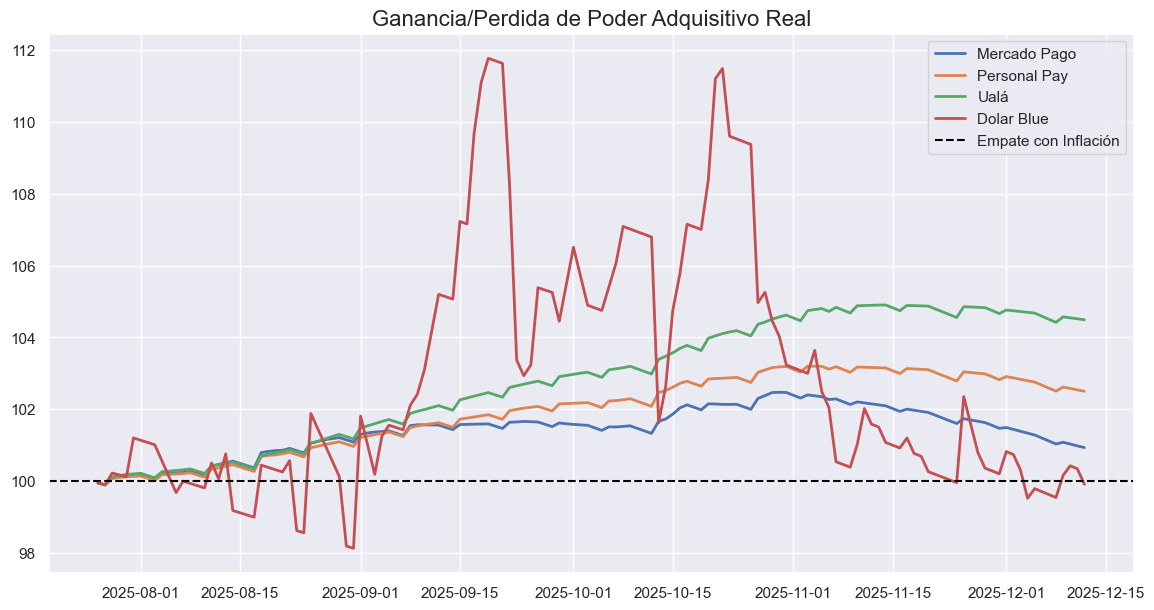

In [7]:
# Calcular la Tasa Real ----> (Rendimiento - Inflacion)
df_real = df_returns.copy()
for col in df_real.columns:
    if 'Inflacion' not in col:
        df_real[col] = df_real[col] - df_returns['Inflacion']

# quitar la columna de inflacion para graficar solo activos
df_real = df_real.drop(columns=['Inflacion'])

#acumulamos para ver la historia completa
df_real_cum = (1 + df_real/100).cumprod() * 100

plt.figure(figsize=(14, 7))
for col in df_real_cum.columns:
    plt.plot(df_real_cum.index, df_real_cum[col], label=col, linewidth=2)

plt.axhline(100, color='black', linestyle='--', label='Empate con Inflación')
plt.title("Ganancia/Perdida de Poder Adquisitivo Real", fontsize=16)
plt.legend()
plt.show()

Observación: 

el dólar cruzó la línea de la inflacion (100) y se fue al suelo, a fines de noviembre el dólar pasó a ser una pérdida real